# All metrics - correlation analysis

In [63]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# Load dataframes w/ stats

In [28]:
# Load extra infos about parent bucket sequences
summary_extracted_sequences_means = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "03_summary_extracted_sequences.csv"))
#summary_extracted_sequences_means.head(2)

In [29]:
# Load alignment results 
stats_alignments_full = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_full.csv"))
stats_alignments_full_dynamic = stats_alignments_full[stats_alignments_full.method == "dynamic"]
#stats_alignments_full_dynamic.head(2)

In [53]:
refs_in_bucket = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_reference_in_bucket.csv"))

In [54]:
merged = summary_extracted_sequences_means.merge(stats_alignments_full_dynamic, on = ["family", "benchmarking_dataset"])
merged = merged.merge(refs_in_bucket, on = ["family", "bucket_size"])
merged.columns

Index(['family', 'benchmarking_dataset', 'name_x', 'plddt_mean_extracted',
       'plddt_min_extracted', 'plddt_max_extracted', 'name_y', 'sp', 'tc',
       'column', 'method', 'bucket_size', 'align_method', 'tree_method',
       'dynamicX_label', 'dynamicX_val', 'master_msa', 'slave_msa', 'tag',
       'plddt_mean', 'plddt_min', 'plddt_max', 'realtime', '%cpu', 'rchar',
       'wchar', 'syscr', 'syscw', 'read_bytes', 'write_bytes', '%mem', 'vmem',
       'rss', 'peak_vmem', 'peak_rss', 'vol_ctxt', 'inv_ctxt', 'task',
       'subset', 'n_sequences', 'mean_length', 'min_length', 'max_length',
       'file', 'size_group', 'perc_ref_total', 'approach', 'fam_approach',
       'type', 'perc_refs_extracted'],
      dtype='object')

In [61]:
df_for_corr = merged[["family", "plddt_mean_extracted", "plddt_min_extracted", "tc", "sp"]]
correlation_vars = ["plddt_mean_extracted", "sp", "tc", "column",
                    "plddt_mean", "plddt_min",  "plddt_max", "realtime",
                    "n_sequences", "mean_length", "perc_ref_total",
                    "dynamicX_val", "master_msa", "perc_refs_extracted"]
df =  merged[correlation_vars]

In [65]:
#corr =df.corr()
#corr.style.background_gradient(cmap='coolwarm')

df.columns = ["AF2_plddt_mean_extracted", "SCORE_sp", "SCORE_tc", "SCORE_column",
                    "AF2_plddt_mean", "AF2_plddt_min",  "AF2_plddt_max", "realtime",
                    "FAMILY_n_sequences", "FAMILY_seq_mean_length", "FAMILY_%refs_in_total",
                    "DYNAMIC_X", "DYNAMIC_master_msa", "FAMILY_%refs_in_parent"]

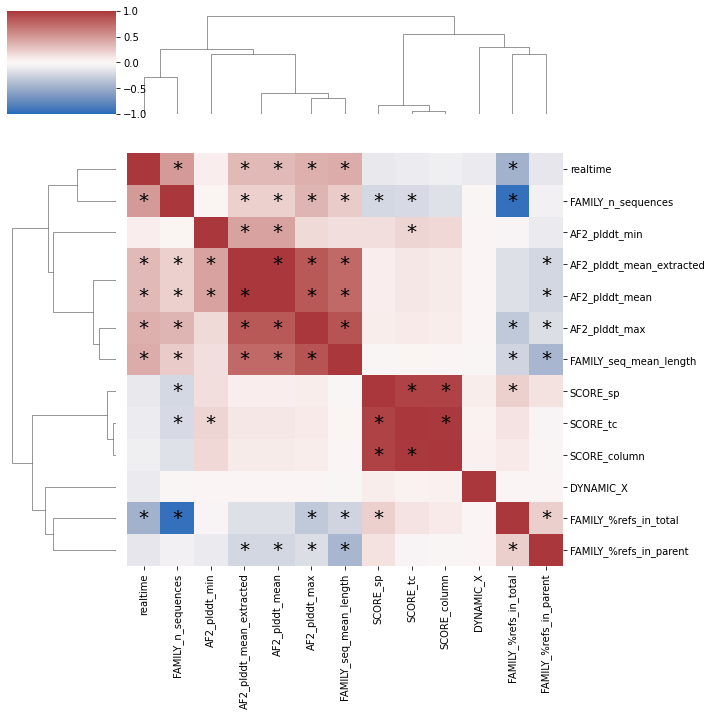

In [66]:
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)